<a href="https://colab.research.google.com/github/Cairo-Henrique/BeatsPerMinute-Prediction/blob/main/BeatsPerMinute_Prediction_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --output train.csv https://drive.google.com/uc?id=1Ts7jkBzixA0CeJj2qI-AnOfQBw2dWX7p
!gdown --output test.csv https://drive.google.com/uc?id=1HCEoEKoIIqPqhD4qeEs2Tp-cV307imaG

Downloading...
From: https://drive.google.com/uc?id=1Ts7jkBzixA0CeJj2qI-AnOfQBw2dWX7p
To: /content/train.csv
100% 61.8M/61.8M [00:01<00:00, 55.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HCEoEKoIIqPqhD4qeEs2Tp-cV307imaG
To: /content/test.csv
100% 19.0M/19.0M [00:00<00:00, 83.9MB/s]


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()
#test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [ ]:
train_without_id = train.drop('id', axis=1)
train_without_id.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


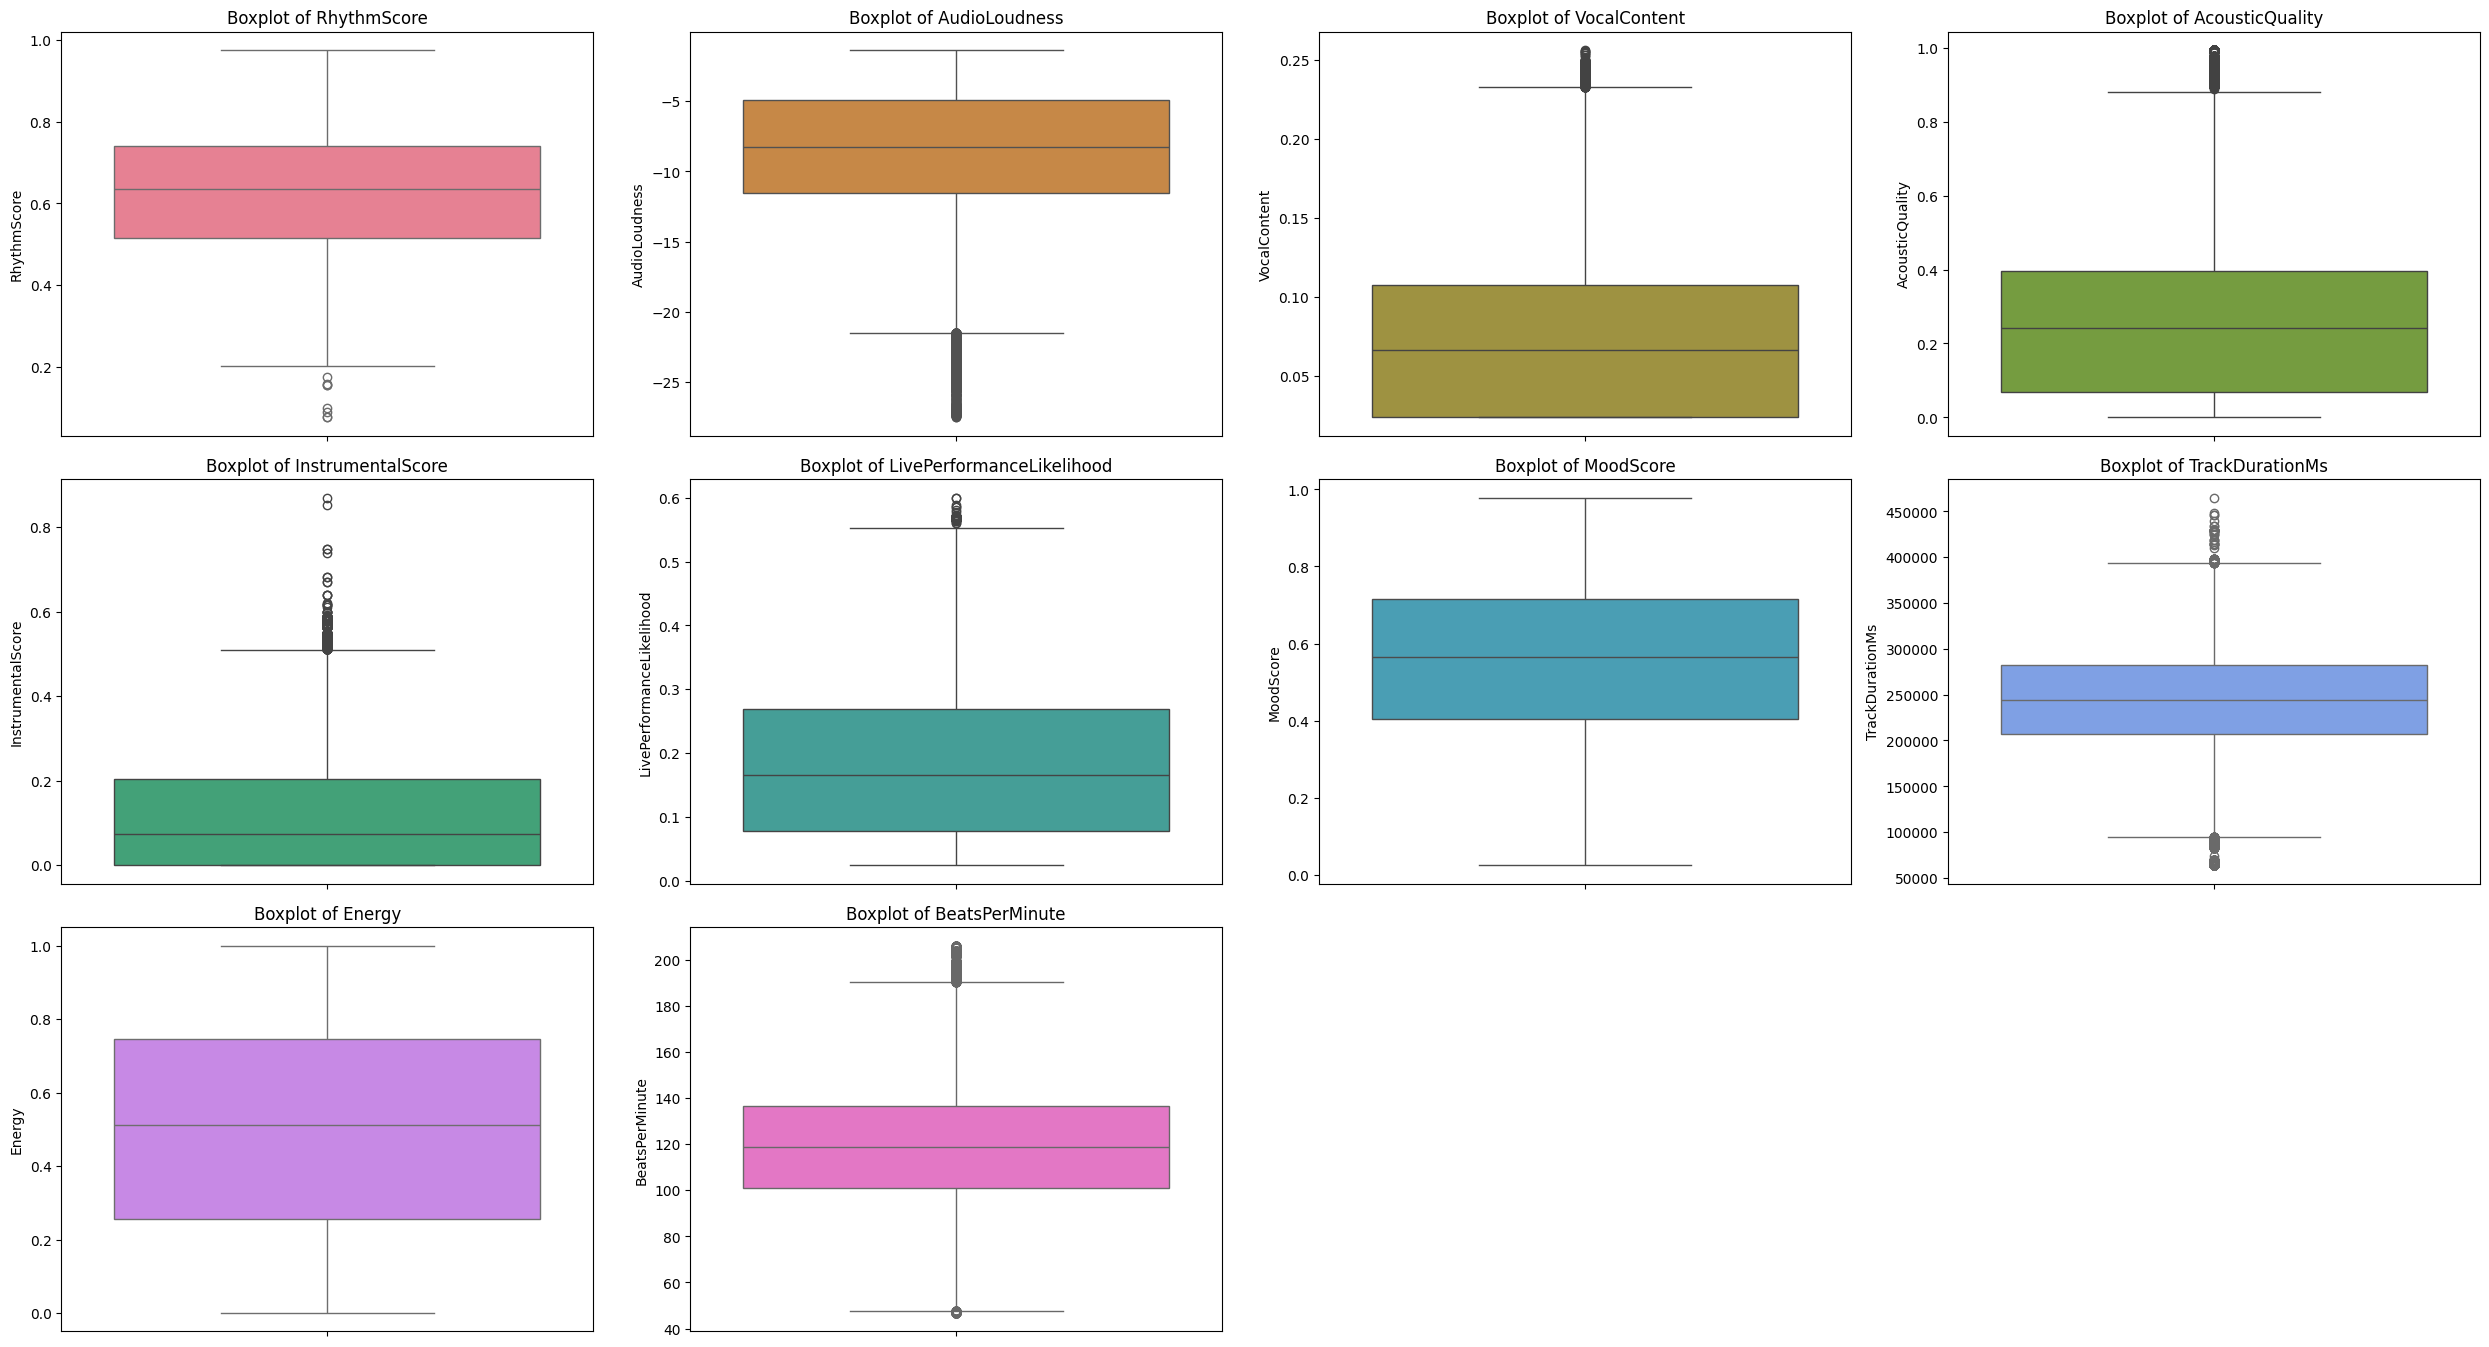

In [ ]:
numerical_cols = train_without_id.columns

# Define color palette
palette = sns.color_palette("husl", len(numerical_cols))

#to show Outliers in data
plt.figure(figsize=(25, 18))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=train[col], color=palette[i-1])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
def remove_outliers_iqr(df, columns=None, k=1.5):
    """
    Remove outliers das colunas numéricas usando o critério do IQR.

    df: DataFrame de entrada
    columns: lista de colunas a aplicar (se None, aplica em todas numéricas)
    k: fator multiplicador do IQR (1.5 é padrão)
    """
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns

    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

# --- Uso ---
train_clean = remove_outliers_iqr(train, numerical_cols, k=1.5)

print("Shape antes:", train.shape)
print("Shape depois:", train_clean.shape)

train_original = train.copy()

Shape antes: (524164, 11)
Shape depois: (505206, 11)


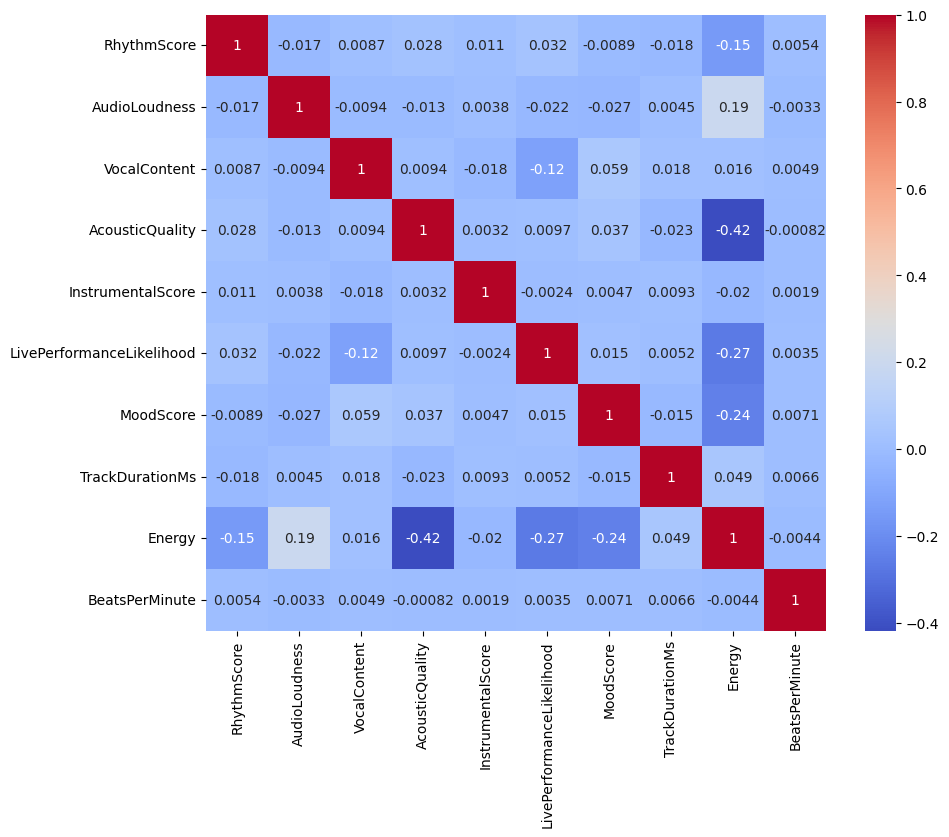

In [ ]:
corr_matrix = train_without_id.corr()  # Correlação de Pearson por padrão

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Ajusta e transforma treino
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Features e target
features = [i for i in train.columns if i not in ["BeatsPerMinute", "id"]]
x = train[features]
y = train["BeatsPerMinute"]

def objective(trial):
    # Espaço de busca para KNN
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 50),     # nº de vizinhos
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),  # distância: 1=Manhattan, 2=Euclidiana
        "leaf_size": trial.suggest_int("leaf_size", 10, 100)  # otimização da árvore
    }

    model = KNeighborsRegressor(**params, n_jobs=-1)

    # Validação cruzada (neg RMSE)
    scores = cross_val_score(
        model, x, y,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    return -scores.mean()  # RMSE médio

# Estudo do Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Melhores params:", study.best_params)
print("Melhor RMSE:", study.best_value)

[I 2025-09-30 00:08:19,559] A new study created in memory with name: no-name-fee4583e-7ac0-4e6c-9eff-216c4cbb6355


  0%|          | 0/30 [00:00<?, ?it/s]

[W 2025-09-30 00:08:27,872] Trial 0 failed with parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1, 'leaf_size': 35} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1574358879.py", line 23, in objective
    scores = cross_val_score(
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 684, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwarg

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

param_distributions = {
    "n_estimators": [30, 50, 100],      # nº de árvores
    "max_depth": [None, 5, 10, 20, 30],         # profundidade máxima
    "min_samples_split": [2, 5, 10],            # mínimo p/ split
    "min_samples_leaf": [1, 2, 4],              # mínimo p/ folha
    "max_features": ["sqrt", "log2", None],     # nº de features consideradas por split
    "bootstrap": [True, False]                  # amostragem com/sem reposição
}

model = RandomForestRegressor(
    random_state=42,
    verbose=2,
)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#train = train_clean

features = [i for i in train.columns if i not in ["BeatsPerMinute", "id"]]
x = train[features]
y = train["BeatsPerMinute"]

#x, x_test = normalize(x, test[features])

search.fit(x, y)
print("Melhores params:", search.best_params_)
print("Melhor RMSE:", np.sqrt(-search.best_score_))


In [ ]:
# com hyperparameter search
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_split = 8,
    min_samples_leaf = 2,
    max_features= None,
    bootstrap= True,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# com hyperparameter search
model = HistGradientBoostingRegressor(
    min_samples_leaf= 20,
    max_leaf_nodes= 15,
    max_iter= 3000,
    max_depth= 10,
    learning_rate= 0.08,
    random_state=42)

In [ ]:
# com hyperparameter search
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=-1,
    subsample=0.7,
    colsample_bytree=0.9,
    random_state=42
)

In [ ]:
# com hyperparameter search
model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.06,
    depth=10,
    l2_leaf_reg=1,
    bagging_temperature=0.1,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

In [ ]:
# com hyperparameter search
model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.7,
    reg_lambda=1,
    reg_alpha=0,
    random_state=42,
    tree_method="hist"
)


In [ ]:
# com hyperparameter search
model = KNeighborsRegressor(
    n_neighbors= 50,
    weights= 'uniform',
    p= 1,
    leaf_size= 80
)

In [ ]:
# Testando o modelo com train_test_split

print("Modelo:", type(model).__name__)

from sklearn.model_selection import train_test_split

#train = train_clean

features = [i for i in train.columns if i not in ["BeatsPerMinute", "id"]]
x = train[features]
y = train["BeatsPerMinute"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#x_train, x_test = normalize(x_train, x_test)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Métricas
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

In [ ]:
# Treinando o modelo final

#train = train_clean

features = [i for i in train.columns if i not in ["BeatsPerMinute", "id"]]
x = train[features]
y = train["BeatsPerMinute"]
x_test = test[features]

x, x_test = normalize(x, x_test)

model.fit(x, y)

y_pred = model.predict(x_test)



In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

features = [i for i in train.columns if i not in ["BeatsPerMinute", "id"]]
x = train[features]
y = train["BeatsPerMinute"]
x_test = test[features]

x, x_test = normalize(x, x_test)

# Definição dos modelos com os melhores hiperparâmetros encontrados
# com hyperparameter search
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_split = 8,
    min_samples_leaf = 2,
    max_features= None,
    bootstrap= True,
    random_state=42,
    n_jobs=-1
)

hgb = HistGradientBoostingRegressor(
    min_samples_leaf=20,
    max_leaf_nodes=15,
    max_iter=3000,
    max_depth=10,
    learning_rate=0.08,
    random_state=42
)

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=-1,
    subsample=0.7,
    colsample_bytree=0.9,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.7,
    reg_lambda=1,
    reg_alpha=0,
    random_state=42,
    tree_method="hist"
)

#rmse = [26.38823, 26.38706, 26.38811]

rmse = [26.38706, 26.38811]

weights = [1/i for i in rmse]
weights = [weight * (1 / np.sum(weights)) for weight in weights]

# Ensemble - Voting Regressor
ensemble = VotingRegressor(
    estimators=[
        ("hgb", hgb),
        ("lgbm", lgbm)
    ],
    weights=weights
)

# Treinamento
ensemble.fit(x, y)

# Predição
y_pred = ensemble.predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 524164, number of used features: 9
[LightGBM] [Info] Start training from score 119.034899


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Create prediction csv

prediction = pd.DataFrame()
prediction['id'] = test['id']
prediction['BeatsPerMinute'] = y_pred
#prediction.to_csv(f'prediction_{type(model).__name__}.csv', index=False)
prediction.to_csv(f'prediction_ensemble_pesos_1rmse_normalized_hgb_lgbm.csv', index=False)

In [ ]:
# Show most important columns

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))

In [ ]:
import patsy
import statsmodels.api as sm

formula = "BeatsPerMinute ~ RhythmScore + AudioLoudness + VocalContent + AcousticQuality + InstrumentalScore + LivePerformanceLikelihood	+ MoodScore	+ TrackDurationMs + Energy"

y, X = patsy.dmatrices(formula, data=train, return_type="dataframe")

modelo = sm.OLS(y, X).fit()

print(modelo.summary())